# Сверточная нейронная сеть

Имя, Фамилия: Лидия Карпович
---

В этом задании вы научитесь работать с изображениями, а также построите сверточную нейронную сеть и сравните ее с полносвязной сетью из предыдущего домашнего задания.




In [30]:
from torch import nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import trange

import cv2

# Задание 1: Работа с изображениями (1 балл)

Загрузите изображение `lena.png` в переменную `lena`. Отобразите результат на экран. Убедитесь, что `opencv` открывает изображение в формате `BGR`.

In [ ]:
!wget -O lena.png https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/viz/lena.png

--2025-02-18 11:48:51--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/viz/lena.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488594 (477K) [image/png]
Saving to: ‘lena.png’

lena.png            100%[===================>] 477.14K  --.-KB/s    in 0.007s  

2025-02-18 11:48:51 (62.2 MB/s) - ‘lena.png’ saved [488594/488594]



Размерность изображения: (512, 512, 3)


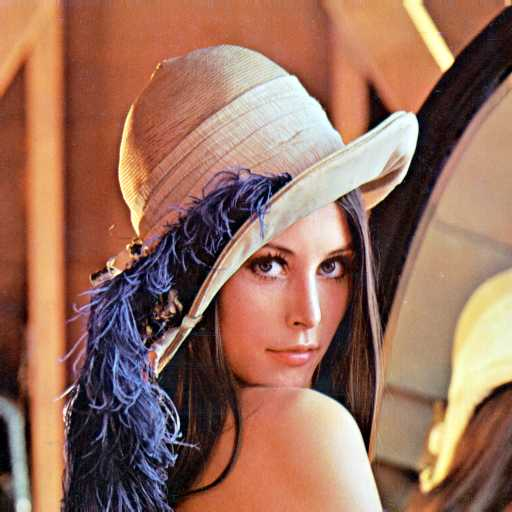

In [ ]:
from google.colab.patches import cv2_imshow

lena = cv2.imread('lena.png')
print("Размерность изображения:", lena.shape)
cv2_imshow(lena)

## 1.1 Перевод в RGB

Переведите изображение `lena` в RGB несколькими способами:

*   c помощью функций split & merge;
*   с помощью индексации в numpy;
*   с помощью cvtColor.


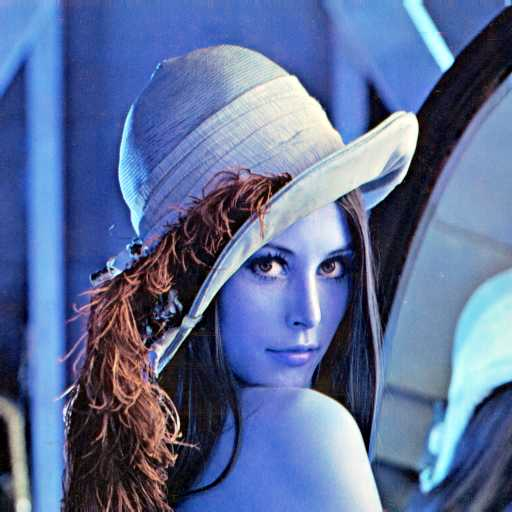

In [ ]:
#c помощью функций split & merge

b, g, r = cv2.split(lena)
lena_rgb_split_merge = cv2.merge([r, g, b])
cv2_imshow(lena_rgb_split_merge)

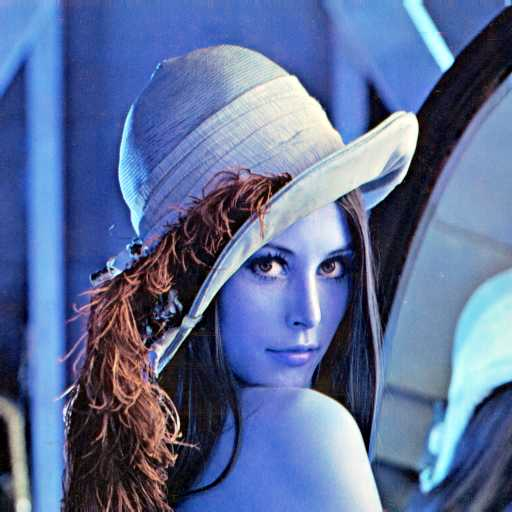

In [ ]:
#с помощью индексации в numpy

lena_rgb_numpy = lena[:, :, ::-1]
cv2_imshow(lena_rgb_numpy)

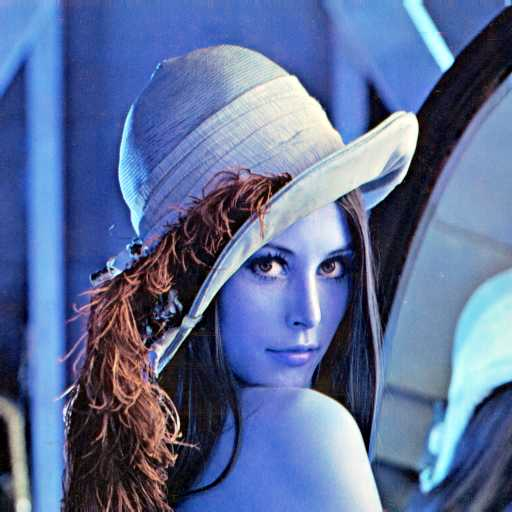

In [ ]:
#с помощью cvtColor

lena_rgb_cvt = cv2.cvtColor(lena, cv2.COLOR_BGR2RGB)
cv2_imshow(lena_rgb_cvt)

## 1.2 Перестановка

Поменяйте местами левую верхнюю и правую нижнюю четвертинки изображения `lena` и отобразите результат на экран.

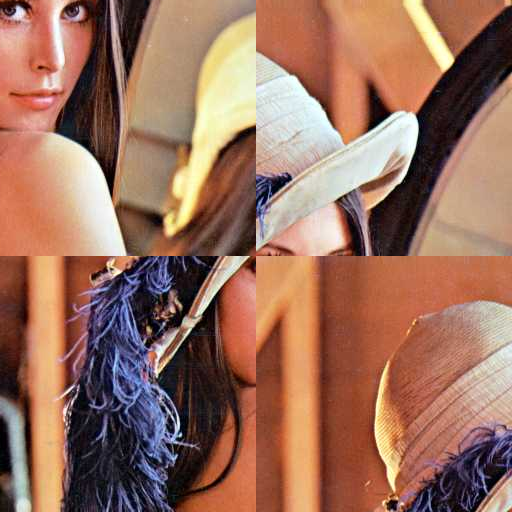

In [ ]:
h, w, _ = lena.shape
top_left = lena[:h//2, :w//2]
bottom_right = lena[h//2:, w//2:]
lena_swap = lena.copy()

lena_swap[:h//2, :w//2] = bottom_right
lena_swap[h//2:, w//2:] = top_left
cv2_imshow(lena_swap)

## 1.3 Оттенки серого

Усредните значения всех трех цветовых каналов `lena` в каждый из каналов итогового изображения `lena_gray_my`. Переведите исходное цветное изображение `lena` в изображение в градациях серого с помощью функции `cvtColor`. (`lena_gray_cvt`). Вычислите модуль разности между изображениями `lena_gray_my` и `lena_gray_cvt` и отобразите ее на экране.


lena_gray_my (усреднение каналов):


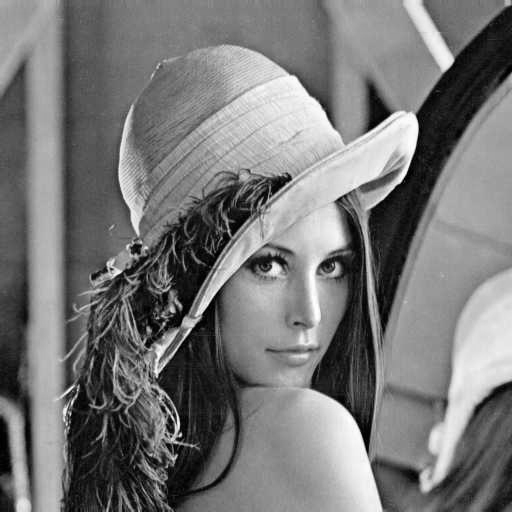

lena_gray_cvt (OpenCV):


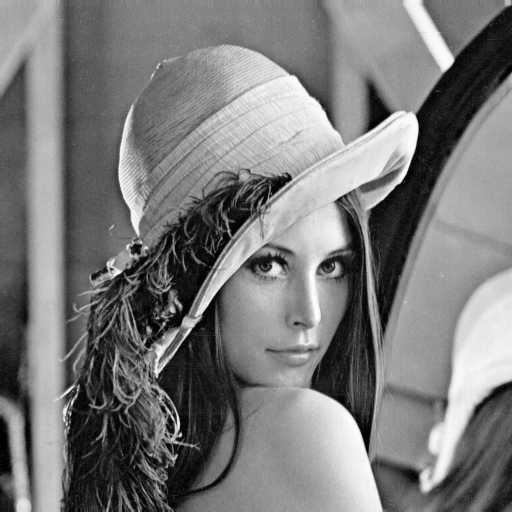

Модуль разности изображений:


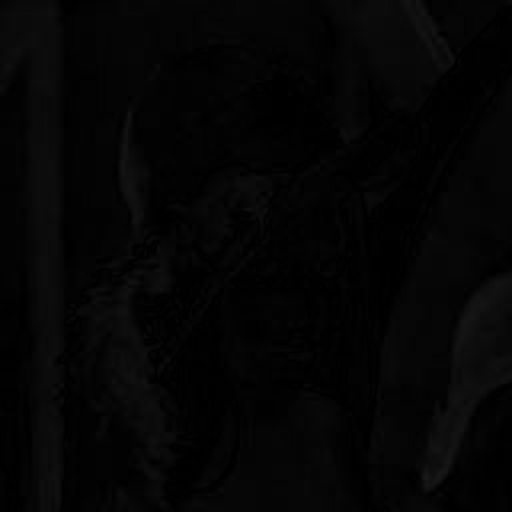

In [ ]:
lena_gray_my = np.mean(lena, axis=2).astype(np.uint8)
lena_gray_cvt = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)
diff = cv2.absdiff(lena_gray_my, lena_gray_cvt)
print("lena_gray_my (усреднение каналов):")
cv2_imshow(lena_gray_my)

print("lena_gray_cvt (OpenCV):")
cv2_imshow(lena_gray_cvt)

print("Модуль разности изображений:")
cv2_imshow(diff)


## 1.4 Координата яркости

Переведите изображение `lena` в одно из цветовых пространств (`cvtColor`) с выделенной координатой яркости (`HSV`, `HSL`, `HSB`, `CIE Lab`), инвертируйте яркостную составляющую, переведите обратно в `RGB`. Отобразите результат.

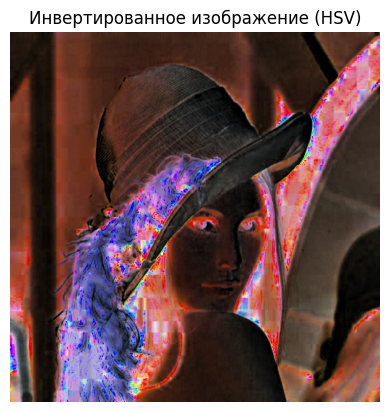

In [ ]:
lena_hsv = cv2.cvtColor(lena, cv2.COLOR_BGR2HSV)
lena_hsv[..., 2] = 255 - lena_hsv[..., 2]
lena_inverted = cv2.cvtColor(lena_hsv, cv2.COLOR_HSV2BGR)
plt.imshow(cv2.cvtColor(lena_inverted, cv2.COLOR_BGR2RGB))
plt.title('Инвертированное изображение (HSV)')
plt.axis('off')
plt.show()


# Задание 2: Одномерная свертка (2 балла)

Начнем с одномерных сигналов — например, это могут быть различные временные ряды.

## 1.1 Реализация

Реализуйте функцию, вычисляющую одномерную свертку.


In [ ]:
def t_convolve(signal: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Вычисляет свертку сигнала с ядром без отступов.

    Эта функция реализует дискретную свертку одномерного сигнала с ядром.
    Важно отметить, что ядро переворачивается перед выполнением свертки,
    что соответствует математическому определению свертки. Результатом
    является сигнал меньшего размера, чем входной сигнал, так как отступы
    не используются.

    Args:
        signal (np.ndarray): Входной сигнал.
        kernel (np.ndarray): Ядро свертки.

    Returns:
        np.ndarray: Свернутый сигнал.
                    Размерность выходного сигнала равна len(signal) - len(kernel) + 1.
    """
    kernel = kernel[::-1]
    output_size = len(signal) - len(kernel) + 1
    output = np.zeros(output_size)

    for i in range(output_size):
        output[i] = np.sum(signal[i:i+len(kernel)] * kernel)

    return output

Проверьте правильность реализации, сравнив с реализацией из `scipy.signal.convolve` (используйте `numpy.testing.assert_allclose`)

In [ ]:
from scipy.signal import convolve
import numpy.testing as npt

signal = np.array([1, 2, 3, 4, 5])
kernel = np.array([1, 0, -1])
result_my = t_convolve(signal, kernel)
result_scipy = convolve(signal, kernel, mode='valid')
npt.assert_allclose(result_my, result_scipy, atol=1e-8)
print("Тест пройден успешно. Результаты совпадают.")

Тест пройден успешно. Результаты совпадают.


## 1.2 Удаление шума

Посмотрим, как операция свертки может помочь нам убрать шум из сигнала.

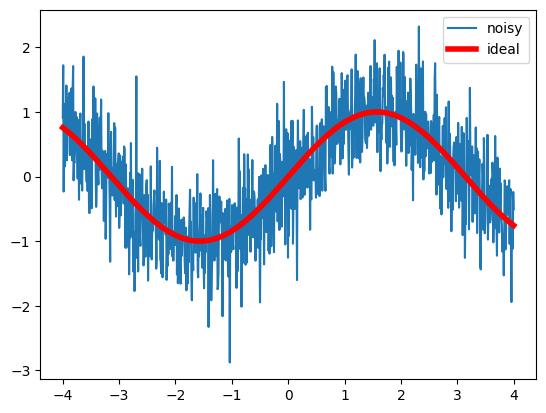

In [ ]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)
plt.show()

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. [ЗБЧ](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%BA%D0%BE%D0%BD_%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B8%D1%85_%D1%87%D0%B8%D1%81%D0%B5%D0%BB)). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

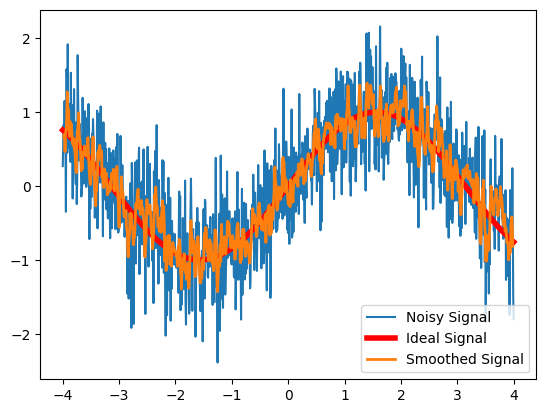

In [ ]:
kernel = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
smoothed_signal = t_convolve(noisy_signal, kernel)

plt.plot(x, noisy_signal, label='Noisy Signal')
plt.plot(x, signal, 'r', label='Ideal Signal', linewidth=4)
plt.plot(x[2:-2], smoothed_signal, label='Smoothed Signal', linewidth=2)
plt.legend(loc=0)
plt.show()

Отобразите на одном графике сигнал, зашумленную и восстановленные версии.

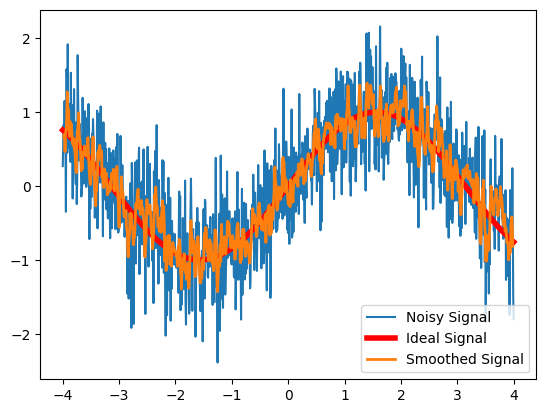

In [ ]:
plt.plot(x, noisy_signal, label='Noisy Signal')
plt.plot(x, signal, 'r', label='Ideal Signal', linewidth=4)
plt.plot(x[2:-2], smoothed_signal, label='Smoothed Signal', linewidth=2)
plt.legend(loc=0)
plt.show()

Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

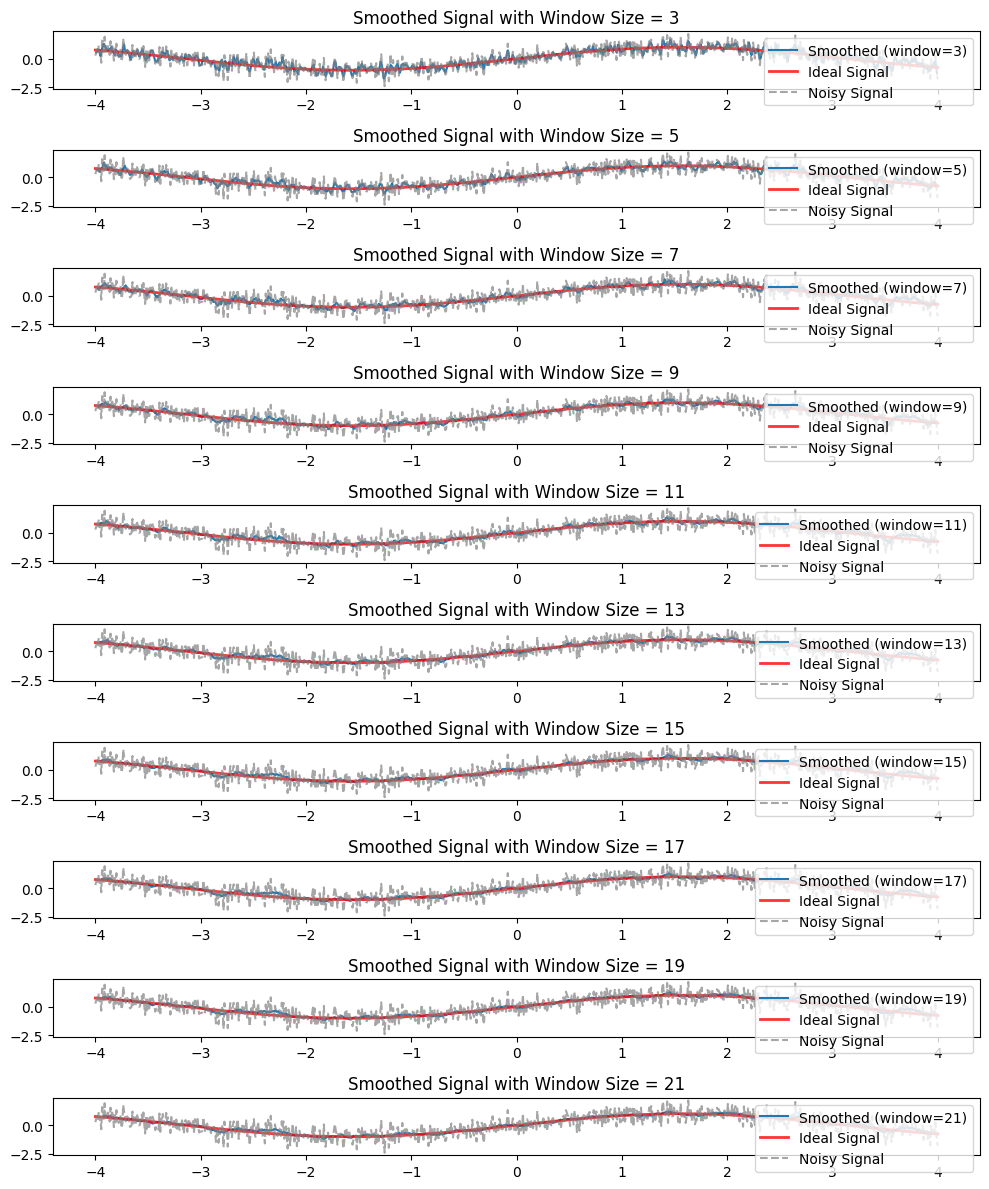

In [ ]:
window_sizes = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

fig, axes = plt.subplots(len(window_sizes), 1, figsize=(10, 12))

for i, size in enumerate(window_sizes):
    kernel = np.ones(size) / size
    smoothed_signal = t_convolve(noisy_signal, kernel)
    axes[i].plot(x[size//2:-(size//2)], smoothed_signal, label=f'Smoothed (window={size})')
    axes[i].plot(x, signal, 'r', label='Ideal Signal', linewidth=2, alpha=0.8)
    axes[i].plot(x, noisy_signal, '--', label='Noisy Signal', color='gray', alpha=0.7)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Smoothed Signal with Window Size = {size}')

plt.tight_layout()
plt.show()

# Задание 3: Пулинг (1 балл)

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

## 3.1 Реализация

Реализуйте операции пулинга для цветных изображений.

In [ ]:
from typing import Callable

def pooling(image: np.ndarray, w: int, func: Callable = np.max):
    """
    Применяет операцию пулинга к изображению.

    Args:
        image (np.ndarray): Входное изображение в формате (высота, ширина, каналы).
        w (int): Размер окна пулинга (w x w).
        func (Callable): Функция, используемая для агрегирования значений в окне пулинга.
                         Должна принимать массив и axis=(0, 1) и возвращать одно значение для каждого канала.
                         По умолчанию np.max (максимальный пулинг).

    Returns:
        np.ndarray: Изображение после пулинга с размерами (высота//w, ширина//w, каналы).
    """
    h, w_img, c = image.shape
    h_out = h // w
    w_out = w_img // w
    pooled_image = np.zeros((h_out, w_out, c), dtype=image.dtype)

    for i in range(h_out):
        for j in range(w_out):
            window = image[i*w:(i+1)*w, j*w:(j+1)*w]
            pooled_image[i, j] = func(window, axis=(0, 1))

    return pooled_image


def maxpool(image: np.ndarray, w: int) -> None:
    """
    Применяет операцию максимального пулинга к изображению.

    Args:
        image (np.ndarray): Входное изображение в формате (высота, ширина, каналы).
        w (int): Размер окна пулинга (w x w).
    """
    assert(image.ndim == 3)

    return pooling(image, w, func=np.max)

def medianpool(image: np.ndarray, w: int) -> None:
    """
    Применяет операцию медианного пулинга к изображению.

    Args:
        image (np.ndarray): Входное изображение в формате (высота, ширина, каналы).
        w (int): Размер окна пулинга (w x w).
    """
    assert(image.ndim == 3)

    return pooling(image, w, func=np.median)

## 3.2 Применение

Добавить к изображению `lena.png` [шум соль и перец](https://ru.wikipedia.org/wiki/Salt_and_pepper). Примените медианный пулинг и максимальный пулинг.

Сделайте выводы о том, какой тип пулинга лучше справился с поставленной задачей, и почему.

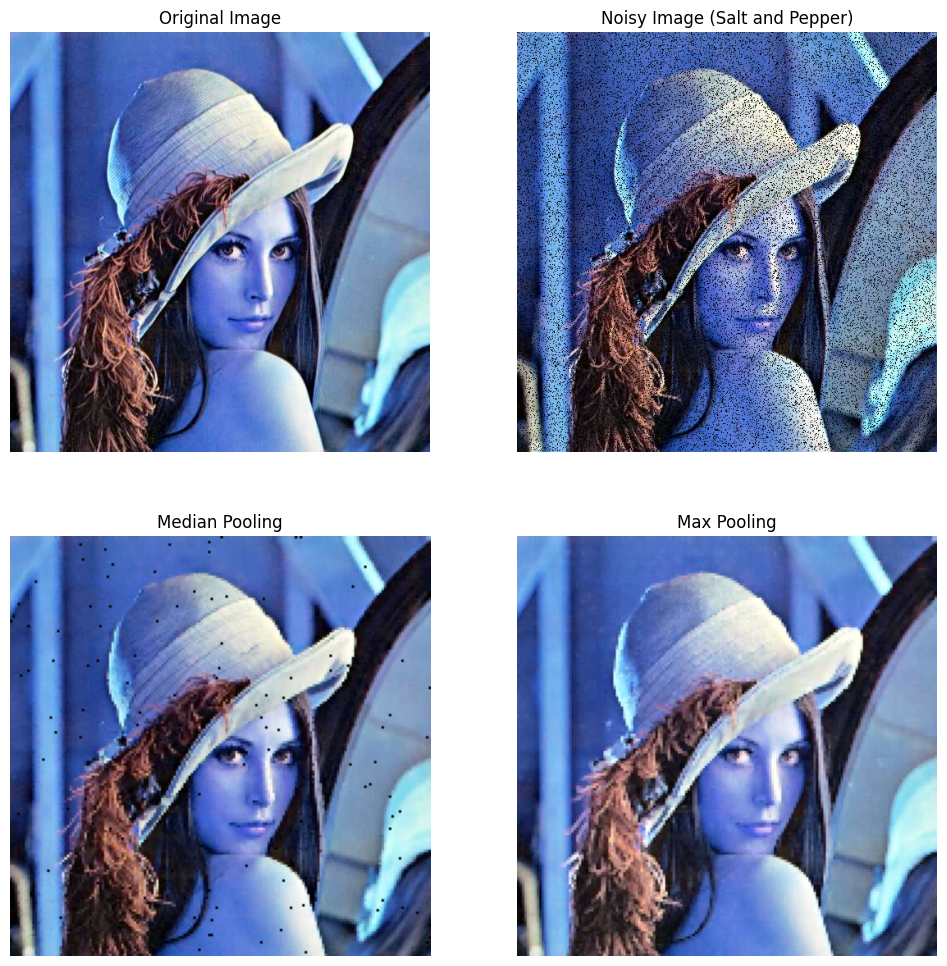

In [ ]:
from typing import Callable

def salt_and_pepper_noise(image: np.ndarray, amount: float = 0.02) -> np.ndarray:
    """
    Добавляет шум соль и перец к изображению.

    Args:
        image (np.ndarray): Входное изображение.
        amount (float): Количество шума (доля пикселей, которые будут шумными).

    Returns:
        np.ndarray: Изображение с добавленным шумом.
    """
    output = np.copy(image)
    total_pixels = image.size
    num_salt = int(total_pixels * amount / 2)
    num_pepper = int(total_pixels * amount / 2)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in image.shape]
    output[salt_coords[0], salt_coords[1], :] = 1
    pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in image.shape]
    output[pepper_coords[0], pepper_coords[1], :] = 0

    return output

noisy_image = salt_and_pepper_noise(lena, amount=0.05)
median_image = medianpool(noisy_image, w=3)
max_image = maxpool(noisy_image, w=3)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(lena)
plt.title("Original Image")
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(noisy_image)
plt.title("Noisy Image (Salt and Pepper)")
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(median_image)
plt.title("Median Pooling")
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(max_image)
plt.title("Max Pooling")
plt.axis('off')

plt.show()


# Задание 4: Сверточная нейронная сеть (6 баллов)

Реализуйте слои для сверточной нейронной сети и постройте ее на датасете **CIFAR-10** (Canadian Institute For Advanced Research).

*Подробнее про данные можно посмотреть [тут](https://www.cs.toronto.edu/~kriz/cifar.html)*

ВАЖНО! Для получения полного балла достаточно только реализации `forward` методов.

Реализация без PyTorch (наследование от класса `Module` из прошлых дз) обоих слоев даст **дополнительные 5 баллов**.

## 4.1 Сверточный слой (2 балла)

Реализуйте сверточный слой для двумерных данных:

In [ ]:
import torch

class Conv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int = 1, padding: int = 0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = np.zeros(out_channels, dtype=np.float32)
        self.weight = np.random.randn(out_channels, in_channels, kernel_size, kernel_size).astype(np.float32) * np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, in_channels, input_height, input_width = x.shape

        if self.padding > 0:
            x = torch.nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        padded_height, padded_width = x.shape[2], x.shape[3]
        output_height = (padded_height - self.kernel_size) // self.stride + 1
        output_width = (padded_width - self.kernel_size) // self.stride + 1
        output = torch.zeros((batch_size, self.out_channels, output_height, output_width), dtype=torch.float32)

        for b in range(batch_size):
            for c_out in range(self.out_channels):
                for i in range(output_height):
                    for j in range(output_width):
                        region = x[b, :, i * self.stride:i * self.stride + self.kernel_size, j * self.stride:j * self.stride + self.kernel_size]
                        output[b, c_out, i, j] = torch.sum(region * torch.tensor(self.weight[c_out])) + self.bias[c_out]

        return output


## 4.2 Слой макс-пулинга (2 балла)

Реализуйте слой макс-пулинга для двумерных данных:

In [32]:
class MaxPool2D(nn.Module):
    def __init__(self, pool_size: int, stride: int = None):
        super().__init__()
        self.pool_size = pool_size
        self.stride = stride if stride is not None else pool_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, channels, height, width = x.shape
        output_height = (height - self.pool_size) // self.stride + 1
        output_width = (width - self.pool_size) // self.stride + 1
        out = torch.zeros((batch_size, channels, output_height, output_width), dtype=x.dtype)

        for i in range(output_height):
            for j in range(output_width):
                h_start, h_end = i * self.stride, i * self.stride + self.pool_size
                w_start, w_end = j * self.stride, j * self.stride + self.pool_size
                out[:, :, i, j] = torch.max(torch.max(x[:, :, h_start:h_end, w_start:w_end], dim=2).values, dim=2).values

        return out



## Построение нейронной сети (2 балла)

Постройте сверточную нейронную сеть на датасете **CIFAR-10**.

ВАЖНО! Для построения CNN можно использовать только кастомные слои, написанные в этом и предыдущих дз.

In [33]:
BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor()])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = MaxPool2D(pool_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool.forward(F.relu(self.conv1.forward(x)))  # вызов метода forward явно
        x = self.pool.forward(F.relu(self.conv2.forward(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Инициализация модели
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


CNN(
  (conv1): Conv2d()
  (conv2): Conv2d()
  (pool): MaxPool2D()
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
def calculate_accuracy(model: CNN, dataloader: DataLoader) -> float:
  """
  Вычисляет точность модели на заданном даталоадере.

  Args:
    model (NeuralNetwork): Модель для тестирования.
    dataloader (DataLoader): Загрузчик данных, предоставляющий батчи тестовых данных.

  Returns:
    float: Accuarcy.
  """
  correct = 0
  total = 0

  for data in dataloader:
    inputs, labels = data
    inputs = inputs

    with torch.no_grad():
      outputs = model(inputs)
    predicted = np.argmax(outputs, axis=1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  return correct / total

In [ ]:
calculate_accuracy(model,testloader)

Сравните построенную сверточную нейронную сеть с полносвязной нейронной сетью из предыдущего домашнего задания.

# Домашнее задание № 4

Выполните задания в этом ноутбуке и напишите полученные выводы.

+ Мягкий дедлайн: `19.02.25 23:59`
+ Жесткий дедлайн: `26.02.25 23:59` (половина баллов)


После жесткого дедлайна задание не принимается.

К сожалению, обучить так и не получилось. Не хватает вычислительных мощностей, коллаб тоже не справился.
Но результаты, по-хорошему, должны быть лучше, чем у полносвязной нейронной сети